In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout

In [3]:
def define_discriminator(in_shape=(28, 28, 1)):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), strides=(2, 2),
                     padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt, metrics=['accuracy'])
    return model

In [4]:
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7, 7), activation='sigmoid', padding='same'))
    return model

In [5]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [6]:
def load_real_samples():
    (trainX, _), (_, _) = load_data()
    X = np.expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = X / 255.0
    return X

In [7]:
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    return X, y

In [8]:
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [9]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = np.zeros((n_samples, 1))
    return X, y

In [10]:
def save_plot(examples, epoch, n=10):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

In [11]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' %
          (acc_real*100, acc_fake*100))
    save_plot(x_fake, epoch)
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

In [12]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(
                g_model, latent_dim, half_batch)
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            d_loss, _ = d_model.train_on_batch(X, y)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d=%.3f, g=%.3f' %
                  (i+1, j+1, bat_per_epo, d_loss, g_loss))
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [13]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()
train(g_model, d_model, gan_model, dataset, latent_dim)

11493376/11490434 [==============================] - 7s 1us/step
>1, 1/234, d=0.688, g=0.719
>1, 2/234, d=0.682, g=0.734
>1, 3/234, d=0.678, g=0.743
>1, 4/234, d=0.672, g=0.762
>1, 5/234, d=0.665, g=0.774
>1, 6/234, d=0.664, g=0.785
>1, 7/234, d=0.656, g=0.794
>1, 8/234, d=0.652, g=0.794
>1, 9/234, d=0.650, g=0.806
>1, 10/234, d=0.646, g=0.802
>1, 11/234, d=0.648, g=0.795
>1, 12/234, d=0.651, g=0.781
>1, 13/234, d=0.651, g=0.768
>1, 14/234, d=0.654, g=0.754
>1, 15/234, d=0.651, g=0.741
>1, 16/234, d=0.654, g=0.729
>1, 17/234, d=0.654, g=0.718
>1, 18/234, d=0.652, g=0.710
>1, 19/234, d=0.648, g=0.703
>1, 20/234, d=0.645, g=0.699
>1, 21/234, d=0.638, g=0.697
>1, 22/234, d=0.634, g=0.695
>1, 23/234, d=0.627, g=0.695
>1, 24/234, d=0.623, g=0.695
>1, 25/234, d=0.614, g=0.695
>1, 26/234, d=0.607, g=0.696
>1, 27/234, d=0.602, g=0.696
>1, 28/234, d=0.589, g=0.697
>1, 29/234, d=0.587, g=0.698
>1, 30/234, d=0.578, g=0.700
>1, 31/234, d=0.567, g=0.700
>1, 32/234, d=0.559, g=0.702
>1, 33/234, d=0.

>2, 41/234, d=0.523, g=0.883
>2, 42/234, d=0.534, g=0.869
>2, 43/234, d=0.527, g=0.860
>2, 44/234, d=0.510, g=0.857
>2, 45/234, d=0.509, g=0.839
>2, 46/234, d=0.505, g=0.850
>2, 47/234, d=0.488, g=0.828
>2, 48/234, d=0.496, g=0.833
>2, 49/234, d=0.500, g=0.847
>2, 50/234, d=0.494, g=0.852
>2, 51/234, d=0.494, g=0.810
>2, 52/234, d=0.506, g=0.780
>2, 53/234, d=0.543, g=0.778
>2, 54/234, d=0.567, g=0.740
>2, 55/234, d=0.585, g=0.744
>2, 56/234, d=0.593, g=0.761
>2, 57/234, d=0.638, g=0.747
>2, 58/234, d=0.666, g=0.753
>2, 59/234, d=0.676, g=0.801
>2, 60/234, d=0.688, g=0.894
>2, 61/234, d=0.703, g=0.938
>2, 62/234, d=0.689, g=0.997
>2, 63/234, d=0.708, g=0.990
>2, 64/234, d=0.702, g=0.990
>2, 65/234, d=0.700, g=0.967
>2, 66/234, d=0.697, g=0.936
>2, 67/234, d=0.707, g=0.885
>2, 68/234, d=0.718, g=0.847
>2, 69/234, d=0.725, g=0.806
>2, 70/234, d=0.731, g=0.758
>2, 71/234, d=0.757, g=0.714
>2, 72/234, d=0.755, g=0.682
>2, 73/234, d=0.771, g=0.684
>2, 74/234, d=0.767, g=0.668
>2, 75/234, d=

>3, 86/234, d=0.703, g=0.726
>3, 87/234, d=0.700, g=0.712
>3, 88/234, d=0.691, g=0.711
>3, 89/234, d=0.690, g=0.716
>3, 90/234, d=0.696, g=0.726
>3, 91/234, d=0.706, g=0.720
>3, 92/234, d=0.696, g=0.733
>3, 93/234, d=0.686, g=0.739
>3, 94/234, d=0.687, g=0.741
>3, 95/234, d=0.689, g=0.739
>3, 96/234, d=0.685, g=0.741
>3, 97/234, d=0.683, g=0.730
>3, 98/234, d=0.690, g=0.740
>3, 99/234, d=0.677, g=0.737
>3, 100/234, d=0.666, g=0.730
>3, 101/234, d=0.672, g=0.736
>3, 102/234, d=0.665, g=0.727
>3, 103/234, d=0.670, g=0.743
>3, 104/234, d=0.669, g=0.755
>3, 105/234, d=0.669, g=0.740
>3, 106/234, d=0.662, g=0.743
>3, 107/234, d=0.658, g=0.747
>3, 108/234, d=0.661, g=0.759
>3, 109/234, d=0.672, g=0.754
>3, 110/234, d=0.670, g=0.748
>3, 111/234, d=0.653, g=0.776
>3, 112/234, d=0.657, g=0.766
>3, 113/234, d=0.656, g=0.772
>3, 114/234, d=0.655, g=0.768
>3, 115/234, d=0.656, g=0.775
>3, 116/234, d=0.648, g=0.770
>3, 117/234, d=0.648, g=0.768
>3, 118/234, d=0.660, g=0.760
>3, 119/234, d=0.649, g=

>4, 130/234, d=0.656, g=0.748
>4, 131/234, d=0.669, g=0.745
>4, 132/234, d=0.664, g=0.731
>4, 133/234, d=0.678, g=0.734
>4, 134/234, d=0.671, g=0.729
>4, 135/234, d=0.689, g=0.731
>4, 136/234, d=0.685, g=0.728
>4, 137/234, d=0.677, g=0.729
>4, 138/234, d=0.676, g=0.721
>4, 139/234, d=0.677, g=0.718
>4, 140/234, d=0.672, g=0.724
>4, 141/234, d=0.690, g=0.720
>4, 142/234, d=0.689, g=0.718
>4, 143/234, d=0.694, g=0.721
>4, 144/234, d=0.698, g=0.700
>4, 145/234, d=0.688, g=0.691
>4, 146/234, d=0.700, g=0.684
>4, 147/234, d=0.687, g=0.682
>4, 148/234, d=0.700, g=0.691
>4, 149/234, d=0.691, g=0.686
>4, 150/234, d=0.705, g=0.707
>4, 151/234, d=0.698, g=0.723
>4, 152/234, d=0.684, g=0.704
>4, 153/234, d=0.704, g=0.718
>4, 154/234, d=0.685, g=0.710
>4, 155/234, d=0.692, g=0.737
>4, 156/234, d=0.698, g=0.728
>4, 157/234, d=0.687, g=0.730
>4, 158/234, d=0.690, g=0.719
>4, 159/234, d=0.690, g=0.710
>4, 160/234, d=0.697, g=0.700
>4, 161/234, d=0.691, g=0.685
>4, 162/234, d=0.708, g=0.693
>4, 163/23

>5, 173/234, d=0.679, g=0.647
>5, 174/234, d=0.672, g=0.648
>5, 175/234, d=0.680, g=0.630
>5, 176/234, d=0.691, g=0.636
>5, 177/234, d=0.684, g=0.637
>5, 178/234, d=0.682, g=0.646
>5, 179/234, d=0.680, g=0.639
>5, 180/234, d=0.710, g=0.638
>5, 181/234, d=0.704, g=0.652
>5, 182/234, d=0.711, g=0.665
>5, 183/234, d=0.722, g=0.676
>5, 184/234, d=0.720, g=0.701
>5, 185/234, d=0.710, g=0.714
>5, 186/234, d=0.722, g=0.718
>5, 187/234, d=0.727, g=0.729
>5, 188/234, d=0.732, g=0.722
>5, 189/234, d=0.731, g=0.739
>5, 190/234, d=0.723, g=0.726
>5, 191/234, d=0.717, g=0.715
>5, 192/234, d=0.724, g=0.701
>5, 193/234, d=0.737, g=0.699
>5, 194/234, d=0.737, g=0.693
>5, 195/234, d=0.728, g=0.692
>5, 196/234, d=0.726, g=0.676
>5, 197/234, d=0.721, g=0.684
>5, 198/234, d=0.730, g=0.686
>5, 199/234, d=0.722, g=0.686
>5, 200/234, d=0.722, g=0.692
>5, 201/234, d=0.713, g=0.701
>5, 202/234, d=0.726, g=0.700
>5, 203/234, d=0.720, g=0.716
>5, 204/234, d=0.722, g=0.719
>5, 205/234, d=0.706, g=0.714
>5, 206/23

>6, 216/234, d=0.697, g=0.682
>6, 217/234, d=0.698, g=0.666
>6, 218/234, d=0.698, g=0.678
>6, 219/234, d=0.701, g=0.682
>6, 220/234, d=0.696, g=0.676
>6, 221/234, d=0.697, g=0.687
>6, 222/234, d=0.694, g=0.688
>6, 223/234, d=0.687, g=0.687
>6, 224/234, d=0.700, g=0.684
>6, 225/234, d=0.700, g=0.680
>6, 226/234, d=0.693, g=0.680
>6, 227/234, d=0.686, g=0.676
>6, 228/234, d=0.686, g=0.676
>6, 229/234, d=0.688, g=0.676
>6, 230/234, d=0.689, g=0.679
>6, 231/234, d=0.684, g=0.695
>6, 232/234, d=0.685, g=0.683
>6, 233/234, d=0.679, g=0.698
>6, 234/234, d=0.679, g=0.701
>7, 1/234, d=0.676, g=0.713
>7, 2/234, d=0.672, g=0.724
>7, 3/234, d=0.683, g=0.714
>7, 4/234, d=0.669, g=0.720
>7, 5/234, d=0.673, g=0.729
>7, 6/234, d=0.670, g=0.729
>7, 7/234, d=0.660, g=0.733
>7, 8/234, d=0.660, g=0.749
>7, 9/234, d=0.671, g=0.743
>7, 10/234, d=0.660, g=0.751
>7, 11/234, d=0.653, g=0.746
>7, 12/234, d=0.656, g=0.743
>7, 13/234, d=0.655, g=0.736
>7, 14/234, d=0.663, g=0.737
>7, 15/234, d=0.670, g=0.719
>7, 

>8, 26/234, d=0.690, g=0.697
>8, 27/234, d=0.679, g=0.691
>8, 28/234, d=0.683, g=0.684
>8, 29/234, d=0.680, g=0.669
>8, 30/234, d=0.680, g=0.679
>8, 31/234, d=0.686, g=0.667
>8, 32/234, d=0.676, g=0.672
>8, 33/234, d=0.682, g=0.679
>8, 34/234, d=0.694, g=0.688
>8, 35/234, d=0.692, g=0.703
>8, 36/234, d=0.680, g=0.717
>8, 37/234, d=0.691, g=0.736
>8, 38/234, d=0.685, g=0.750
>8, 39/234, d=0.683, g=0.760
>8, 40/234, d=0.693, g=0.748
>8, 41/234, d=0.689, g=0.733
>8, 42/234, d=0.683, g=0.719
>8, 43/234, d=0.695, g=0.696
>8, 44/234, d=0.684, g=0.691
>8, 45/234, d=0.690, g=0.676
>8, 46/234, d=0.683, g=0.665
>8, 47/234, d=0.694, g=0.656
>8, 48/234, d=0.687, g=0.653
>8, 49/234, d=0.687, g=0.655
>8, 50/234, d=0.687, g=0.658
>8, 51/234, d=0.693, g=0.652
>8, 52/234, d=0.698, g=0.672
>8, 53/234, d=0.697, g=0.689
>8, 54/234, d=0.695, g=0.708
>8, 55/234, d=0.693, g=0.731
>8, 56/234, d=0.689, g=0.736
>8, 57/234, d=0.692, g=0.724
>8, 58/234, d=0.686, g=0.738
>8, 59/234, d=0.694, g=0.728
>8, 60/234, d=

>9, 71/234, d=0.688, g=0.738
>9, 72/234, d=0.689, g=0.756
>9, 73/234, d=0.685, g=0.770
>9, 74/234, d=0.686, g=0.764
>9, 75/234, d=0.690, g=0.748
>9, 76/234, d=0.683, g=0.730
>9, 77/234, d=0.690, g=0.702
>9, 78/234, d=0.685, g=0.688
>9, 79/234, d=0.683, g=0.680
>9, 80/234, d=0.690, g=0.677
>9, 81/234, d=0.692, g=0.671
>9, 82/234, d=0.686, g=0.676
>9, 83/234, d=0.687, g=0.680
>9, 84/234, d=0.681, g=0.693
>9, 85/234, d=0.690, g=0.707
>9, 86/234, d=0.690, g=0.710
>9, 87/234, d=0.692, g=0.720
>9, 88/234, d=0.691, g=0.719
>9, 89/234, d=0.686, g=0.735
>9, 90/234, d=0.685, g=0.737
>9, 91/234, d=0.691, g=0.721
>9, 92/234, d=0.687, g=0.716
>9, 93/234, d=0.681, g=0.722
>9, 94/234, d=0.690, g=0.715
>9, 95/234, d=0.683, g=0.708
>9, 96/234, d=0.687, g=0.713
>9, 97/234, d=0.684, g=0.704
>9, 98/234, d=0.682, g=0.695
>9, 99/234, d=0.678, g=0.689
>9, 100/234, d=0.677, g=0.684
>9, 101/234, d=0.688, g=0.704
>9, 102/234, d=0.681, g=0.703
>9, 103/234, d=0.684, g=0.709
>9, 104/234, d=0.681, g=0.720
>9, 105/2

>10, 111/234, d=0.686, g=0.717
>10, 112/234, d=0.684, g=0.729
>10, 113/234, d=0.698, g=0.735
>10, 114/234, d=0.694, g=0.738
>10, 115/234, d=0.697, g=0.723
>10, 116/234, d=0.703, g=0.702
>10, 117/234, d=0.705, g=0.702
>10, 118/234, d=0.701, g=0.696
>10, 119/234, d=0.708, g=0.683
>10, 120/234, d=0.704, g=0.658
>10, 121/234, d=0.708, g=0.657
>10, 122/234, d=0.713, g=0.675
>10, 123/234, d=0.705, g=0.699
>10, 124/234, d=0.696, g=0.715
>10, 125/234, d=0.689, g=0.726
>10, 126/234, d=0.694, g=0.749
>10, 127/234, d=0.684, g=0.772
>10, 128/234, d=0.681, g=0.771
>10, 129/234, d=0.676, g=0.768
>10, 130/234, d=0.674, g=0.755
>10, 131/234, d=0.671, g=0.743
>10, 132/234, d=0.658, g=0.726
>10, 133/234, d=0.659, g=0.712
>10, 134/234, d=0.654, g=0.720
>10, 135/234, d=0.664, g=0.707
>10, 136/234, d=0.655, g=0.700
>10, 137/234, d=0.662, g=0.711
>10, 138/234, d=0.663, g=0.729
>10, 139/234, d=0.670, g=0.770
>10, 140/234, d=0.668, g=0.770
>10, 141/234, d=0.676, g=0.768
>10, 142/234, d=0.672, g=0.755
>10, 143

>11, 144/234, d=0.701, g=0.700
>11, 145/234, d=0.703, g=0.691
>11, 146/234, d=0.693, g=0.687
>11, 147/234, d=0.709, g=0.667
>11, 148/234, d=0.704, g=0.680
>11, 149/234, d=0.698, g=0.694
>11, 150/234, d=0.693, g=0.705
>11, 151/234, d=0.683, g=0.717
>11, 152/234, d=0.688, g=0.719
>11, 153/234, d=0.690, g=0.722
>11, 154/234, d=0.689, g=0.729
>11, 155/234, d=0.686, g=0.718
>11, 156/234, d=0.683, g=0.737
>11, 157/234, d=0.680, g=0.729
>11, 158/234, d=0.682, g=0.730
>11, 159/234, d=0.676, g=0.727
>11, 160/234, d=0.680, g=0.738
>11, 161/234, d=0.675, g=0.746
>11, 162/234, d=0.657, g=0.752
>11, 163/234, d=0.664, g=0.735
>11, 164/234, d=0.672, g=0.722
>11, 165/234, d=0.665, g=0.701
>11, 166/234, d=0.665, g=0.710
>11, 167/234, d=0.670, g=0.706
>11, 168/234, d=0.661, g=0.714
>11, 169/234, d=0.671, g=0.728
>11, 170/234, d=0.681, g=0.749
>11, 171/234, d=0.667, g=0.751
>11, 172/234, d=0.672, g=0.744
>11, 173/234, d=0.671, g=0.744
>11, 174/234, d=0.669, g=0.738
>11, 175/234, d=0.674, g=0.723
>11, 176

>12, 178/234, d=0.671, g=0.711
>12, 179/234, d=0.681, g=0.717
>12, 180/234, d=0.678, g=0.707
>12, 181/234, d=0.693, g=0.705
>12, 182/234, d=0.672, g=0.688
>12, 183/234, d=0.688, g=0.689
>12, 184/234, d=0.682, g=0.696
>12, 185/234, d=0.690, g=0.709
>12, 186/234, d=0.688, g=0.720
>12, 187/234, d=0.689, g=0.722
>12, 188/234, d=0.695, g=0.713
>12, 189/234, d=0.687, g=0.698
>12, 190/234, d=0.688, g=0.703
>12, 191/234, d=0.684, g=0.714
>12, 192/234, d=0.694, g=0.720
>12, 193/234, d=0.681, g=0.728
>12, 194/234, d=0.690, g=0.716
>12, 195/234, d=0.685, g=0.685
>12, 196/234, d=0.684, g=0.676
>12, 197/234, d=0.685, g=0.684
>12, 198/234, d=0.686, g=0.717
>12, 199/234, d=0.677, g=0.747
>12, 200/234, d=0.693, g=0.737
>12, 201/234, d=0.689, g=0.733
>12, 202/234, d=0.676, g=0.725
>12, 203/234, d=0.681, g=0.718
>12, 204/234, d=0.677, g=0.688
>12, 205/234, d=0.681, g=0.701
>12, 206/234, d=0.684, g=0.711
>12, 207/234, d=0.686, g=0.730
>12, 208/234, d=0.683, g=0.732
>12, 209/234, d=0.675, g=0.734
>12, 210

>13, 212/234, d=0.690, g=0.706
>13, 213/234, d=0.689, g=0.723
>13, 214/234, d=0.679, g=0.735
>13, 215/234, d=0.681, g=0.736
>13, 216/234, d=0.675, g=0.738
>13, 217/234, d=0.675, g=0.721
>13, 218/234, d=0.673, g=0.711
>13, 219/234, d=0.680, g=0.722
>13, 220/234, d=0.674, g=0.720
>13, 221/234, d=0.670, g=0.712
>13, 222/234, d=0.675, g=0.724
>13, 223/234, d=0.680, g=0.714
>13, 224/234, d=0.679, g=0.710
>13, 225/234, d=0.678, g=0.718
>13, 226/234, d=0.681, g=0.735
>13, 227/234, d=0.682, g=0.724
>13, 228/234, d=0.680, g=0.713
>13, 229/234, d=0.674, g=0.709
>13, 230/234, d=0.690, g=0.698
>13, 231/234, d=0.683, g=0.689
>13, 232/234, d=0.688, g=0.699
>13, 233/234, d=0.684, g=0.718
>13, 234/234, d=0.688, g=0.743
>14, 1/234, d=0.687, g=0.750
>14, 2/234, d=0.683, g=0.734
>14, 3/234, d=0.682, g=0.712
>14, 4/234, d=0.686, g=0.679
>14, 5/234, d=0.687, g=0.671
>14, 6/234, d=0.694, g=0.688
>14, 7/234, d=0.691, g=0.700
>14, 8/234, d=0.680, g=0.714
>14, 9/234, d=0.683, g=0.742
>14, 10/234, d=0.680, g=0.

>15, 13/234, d=0.688, g=0.709
>15, 14/234, d=0.686, g=0.707
>15, 15/234, d=0.686, g=0.699
>15, 16/234, d=0.690, g=0.682
>15, 17/234, d=0.679, g=0.687
>15, 18/234, d=0.687, g=0.700
>15, 19/234, d=0.696, g=0.706
>15, 20/234, d=0.679, g=0.713
>15, 21/234, d=0.682, g=0.727
>15, 22/234, d=0.689, g=0.720
>15, 23/234, d=0.678, g=0.712
>15, 24/234, d=0.682, g=0.717
>15, 25/234, d=0.688, g=0.699
>15, 26/234, d=0.681, g=0.689
>15, 27/234, d=0.682, g=0.684
>15, 28/234, d=0.686, g=0.705
>15, 29/234, d=0.687, g=0.725
>15, 30/234, d=0.680, g=0.749
>15, 31/234, d=0.686, g=0.743
>15, 32/234, d=0.678, g=0.703
>15, 33/234, d=0.689, g=0.675
>15, 34/234, d=0.686, g=0.683
>15, 35/234, d=0.685, g=0.710
>15, 36/234, d=0.682, g=0.741
>15, 37/234, d=0.674, g=0.757
>15, 38/234, d=0.686, g=0.739
>15, 39/234, d=0.675, g=0.694
>15, 40/234, d=0.680, g=0.676
>15, 41/234, d=0.680, g=0.662
>15, 42/234, d=0.680, g=0.670
>15, 43/234, d=0.680, g=0.720
>15, 44/234, d=0.688, g=0.773
>15, 45/234, d=0.700, g=0.756
>15, 46/23

>16, 48/234, d=0.686, g=0.707
>16, 49/234, d=0.697, g=0.761
>16, 50/234, d=0.685, g=0.757
>16, 51/234, d=0.691, g=0.696
>16, 52/234, d=0.686, g=0.667
>16, 53/234, d=0.696, g=0.658
>16, 54/234, d=0.683, g=0.692
>16, 55/234, d=0.695, g=0.740
>16, 56/234, d=0.684, g=0.768
>16, 57/234, d=0.694, g=0.746
>16, 58/234, d=0.677, g=0.726
>16, 59/234, d=0.676, g=0.696
>16, 60/234, d=0.682, g=0.666
>16, 61/234, d=0.684, g=0.658
>16, 62/234, d=0.690, g=0.681
>16, 63/234, d=0.690, g=0.712
>16, 64/234, d=0.682, g=0.754
>16, 65/234, d=0.683, g=0.778
>16, 66/234, d=0.687, g=0.765
>16, 67/234, d=0.681, g=0.695
>16, 68/234, d=0.681, g=0.670
>16, 69/234, d=0.679, g=0.652
>16, 70/234, d=0.679, g=0.664
>16, 71/234, d=0.681, g=0.695
>16, 72/234, d=0.689, g=0.734
>16, 73/234, d=0.674, g=0.758
>16, 74/234, d=0.691, g=0.755
>16, 75/234, d=0.686, g=0.709
>16, 76/234, d=0.690, g=0.681
>16, 77/234, d=0.680, g=0.666
>16, 78/234, d=0.699, g=0.678
>16, 79/234, d=0.688, g=0.718
>16, 80/234, d=0.686, g=0.722
>16, 81/23

>17, 83/234, d=0.690, g=0.710
>17, 84/234, d=0.681, g=0.721
>17, 85/234, d=0.689, g=0.721
>17, 86/234, d=0.691, g=0.744
>17, 87/234, d=0.689, g=0.716
>17, 88/234, d=0.687, g=0.664
>17, 89/234, d=0.686, g=0.670
>17, 90/234, d=0.682, g=0.699
>17, 91/234, d=0.686, g=0.720
>17, 92/234, d=0.679, g=0.738
>17, 93/234, d=0.690, g=0.726
>17, 94/234, d=0.685, g=0.718
>17, 95/234, d=0.687, g=0.708
>17, 96/234, d=0.677, g=0.696
>17, 97/234, d=0.682, g=0.692
>17, 98/234, d=0.683, g=0.687
>17, 99/234, d=0.677, g=0.701
>17, 100/234, d=0.688, g=0.707
>17, 101/234, d=0.686, g=0.721
>17, 102/234, d=0.687, g=0.717
>17, 103/234, d=0.681, g=0.741
>17, 104/234, d=0.688, g=0.721
>17, 105/234, d=0.677, g=0.705
>17, 106/234, d=0.686, g=0.706
>17, 107/234, d=0.687, g=0.694
>17, 108/234, d=0.682, g=0.680
>17, 109/234, d=0.675, g=0.681
>17, 110/234, d=0.691, g=0.694
>17, 111/234, d=0.686, g=0.745
>17, 112/234, d=0.690, g=0.759
>17, 113/234, d=0.685, g=0.730
>17, 114/234, d=0.681, g=0.705
>17, 115/234, d=0.688, g=

>18, 118/234, d=0.688, g=0.762
>18, 119/234, d=0.679, g=0.739
>18, 120/234, d=0.683, g=0.681
>18, 121/234, d=0.685, g=0.679
>18, 122/234, d=0.679, g=0.678
>18, 123/234, d=0.686, g=0.705
>18, 124/234, d=0.687, g=0.715
>18, 125/234, d=0.684, g=0.701
>18, 126/234, d=0.686, g=0.708
>18, 127/234, d=0.679, g=0.720
>18, 128/234, d=0.686, g=0.727
>18, 129/234, d=0.682, g=0.719
>18, 130/234, d=0.685, g=0.725
>18, 131/234, d=0.673, g=0.690
>18, 132/234, d=0.689, g=0.672
>18, 133/234, d=0.686, g=0.689
>18, 134/234, d=0.695, g=0.710
>18, 135/234, d=0.687, g=0.758
>18, 136/234, d=0.686, g=0.754
>18, 137/234, d=0.684, g=0.701
>18, 138/234, d=0.680, g=0.682
>18, 139/234, d=0.685, g=0.681
>18, 140/234, d=0.689, g=0.705
>18, 141/234, d=0.686, g=0.748
>18, 142/234, d=0.677, g=0.761
>18, 143/234, d=0.684, g=0.725
>18, 144/234, d=0.690, g=0.678
>18, 145/234, d=0.691, g=0.682
>18, 146/234, d=0.696, g=0.693
>18, 147/234, d=0.691, g=0.767
>18, 148/234, d=0.684, g=0.749
>18, 149/234, d=0.683, g=0.738
>18, 150

>19, 152/234, d=0.689, g=0.694
>19, 153/234, d=0.685, g=0.671
>19, 154/234, d=0.690, g=0.714
>19, 155/234, d=0.687, g=0.783
>19, 156/234, d=0.677, g=0.789
>19, 157/234, d=0.685, g=0.725
>19, 158/234, d=0.689, g=0.664
>19, 159/234, d=0.685, g=0.634
>19, 160/234, d=0.687, g=0.675
>19, 161/234, d=0.685, g=0.750
>19, 162/234, d=0.694, g=0.819
>19, 163/234, d=0.693, g=0.787
>19, 164/234, d=0.690, g=0.685
>19, 165/234, d=0.685, g=0.637
>19, 166/234, d=0.691, g=0.636
>19, 167/234, d=0.684, g=0.673
>19, 168/234, d=0.690, g=0.724
>19, 169/234, d=0.684, g=0.778
>19, 170/234, d=0.683, g=0.783
>19, 171/234, d=0.685, g=0.741
>19, 172/234, d=0.687, g=0.712
>19, 173/234, d=0.698, g=0.652
>19, 174/234, d=0.677, g=0.638
>19, 175/234, d=0.696, g=0.666
>19, 176/234, d=0.679, g=0.773
>19, 177/234, d=0.684, g=0.811
>19, 178/234, d=0.690, g=0.764
>19, 179/234, d=0.690, g=0.709
>19, 180/234, d=0.691, g=0.672
>19, 181/234, d=0.685, g=0.648
>19, 182/234, d=0.681, g=0.647
>19, 183/234, d=0.680, g=0.710
>19, 184

>20, 186/234, d=0.687, g=0.707
>20, 187/234, d=0.685, g=0.721
>20, 188/234, d=0.688, g=0.713
>20, 189/234, d=0.680, g=0.700
>20, 190/234, d=0.685, g=0.716
>20, 191/234, d=0.687, g=0.703
>20, 192/234, d=0.681, g=0.727
>20, 193/234, d=0.675, g=0.726
>20, 194/234, d=0.680, g=0.702
>20, 195/234, d=0.688, g=0.671
>20, 196/234, d=0.688, g=0.675
>20, 197/234, d=0.687, g=0.700
>20, 198/234, d=0.681, g=0.764
>20, 199/234, d=0.679, g=0.753
>20, 200/234, d=0.686, g=0.728
>20, 201/234, d=0.684, g=0.708
>20, 202/234, d=0.688, g=0.680
>20, 203/234, d=0.683, g=0.656
>20, 204/234, d=0.693, g=0.658
>20, 205/234, d=0.690, g=0.693
>20, 206/234, d=0.681, g=0.734
>20, 207/234, d=0.684, g=0.745
>20, 208/234, d=0.696, g=0.762
>20, 209/234, d=0.686, g=0.730
>20, 210/234, d=0.688, g=0.703
>20, 211/234, d=0.688, g=0.690
>20, 212/234, d=0.693, g=0.683
>20, 213/234, d=0.685, g=0.688
>20, 214/234, d=0.687, g=0.715
>20, 215/234, d=0.687, g=0.734
>20, 216/234, d=0.682, g=0.746
>20, 217/234, d=0.684, g=0.703
>20, 218

>21, 219/234, d=0.688, g=0.749
>21, 220/234, d=0.689, g=0.716
>21, 221/234, d=0.684, g=0.657
>21, 222/234, d=0.681, g=0.649
>21, 223/234, d=0.691, g=0.685
>21, 224/234, d=0.692, g=0.739
>21, 225/234, d=0.684, g=0.744
>21, 226/234, d=0.686, g=0.732
>21, 227/234, d=0.683, g=0.718
>21, 228/234, d=0.680, g=0.703
>21, 229/234, d=0.680, g=0.680
>21, 230/234, d=0.683, g=0.695
>21, 231/234, d=0.685, g=0.747
>21, 232/234, d=0.685, g=0.757
>21, 233/234, d=0.687, g=0.728
>21, 234/234, d=0.690, g=0.672
>22, 1/234, d=0.681, g=0.654
>22, 2/234, d=0.682, g=0.707
>22, 3/234, d=0.690, g=0.744
>22, 4/234, d=0.689, g=0.742
>22, 5/234, d=0.684, g=0.716
>22, 6/234, d=0.686, g=0.672
>22, 7/234, d=0.680, g=0.651
>22, 8/234, d=0.683, g=0.682
>22, 9/234, d=0.692, g=0.743
>22, 10/234, d=0.688, g=0.778
>22, 11/234, d=0.676, g=0.766
>22, 12/234, d=0.680, g=0.737
>22, 13/234, d=0.681, g=0.690
>22, 14/234, d=0.691, g=0.640
>22, 15/234, d=0.691, g=0.623
>22, 16/234, d=0.691, g=0.676
>22, 17/234, d=0.695, g=0.777
>22

>23, 20/234, d=0.675, g=0.686
>23, 21/234, d=0.683, g=0.718
>23, 22/234, d=0.678, g=0.739
>23, 23/234, d=0.680, g=0.758
>23, 24/234, d=0.684, g=0.748
>23, 25/234, d=0.680, g=0.693
>23, 26/234, d=0.698, g=0.649
>23, 27/234, d=0.685, g=0.660
>23, 28/234, d=0.686, g=0.717
>23, 29/234, d=0.691, g=0.755
>23, 30/234, d=0.691, g=0.757
>23, 31/234, d=0.690, g=0.724
>23, 32/234, d=0.679, g=0.693
>23, 33/234, d=0.688, g=0.671
>23, 34/234, d=0.688, g=0.695
>23, 35/234, d=0.685, g=0.707
>23, 36/234, d=0.684, g=0.727
>23, 37/234, d=0.689, g=0.752
>23, 38/234, d=0.681, g=0.730
>23, 39/234, d=0.692, g=0.693
>23, 40/234, d=0.678, g=0.679
>23, 41/234, d=0.685, g=0.693
>23, 42/234, d=0.689, g=0.752
>23, 43/234, d=0.681, g=0.730
>23, 44/234, d=0.688, g=0.672
>23, 45/234, d=0.685, g=0.681
>23, 46/234, d=0.680, g=0.734
>23, 47/234, d=0.693, g=0.777
>23, 48/234, d=0.685, g=0.753
>23, 49/234, d=0.695, g=0.713
>23, 50/234, d=0.683, g=0.664
>23, 51/234, d=0.672, g=0.669
>23, 52/234, d=0.674, g=0.713
>23, 53/23

>24, 55/234, d=0.697, g=0.722
>24, 56/234, d=0.686, g=0.726
>24, 57/234, d=0.685, g=0.729
>24, 58/234, d=0.683, g=0.714
>24, 59/234, d=0.690, g=0.680
>24, 60/234, d=0.692, g=0.691
>24, 61/234, d=0.679, g=0.706
>24, 62/234, d=0.686, g=0.750
>24, 63/234, d=0.685, g=0.782
>24, 64/234, d=0.677, g=0.729
>24, 65/234, d=0.689, g=0.671
>24, 66/234, d=0.687, g=0.685
>24, 67/234, d=0.690, g=0.703
>24, 68/234, d=0.695, g=0.684
>24, 69/234, d=0.682, g=0.735
>24, 70/234, d=0.675, g=0.746
>24, 71/234, d=0.680, g=0.737
>24, 72/234, d=0.691, g=0.720
>24, 73/234, d=0.680, g=0.708
>24, 74/234, d=0.682, g=0.695
>24, 75/234, d=0.684, g=0.709
>24, 76/234, d=0.680, g=0.741
>24, 77/234, d=0.672, g=0.776
>24, 78/234, d=0.682, g=0.730
>24, 79/234, d=0.691, g=0.706
>24, 80/234, d=0.694, g=0.662
>24, 81/234, d=0.690, g=0.664
>24, 82/234, d=0.691, g=0.732
>24, 83/234, d=0.685, g=0.762
>24, 84/234, d=0.687, g=0.747
>24, 85/234, d=0.687, g=0.739
>24, 86/234, d=0.677, g=0.695
>24, 87/234, d=0.680, g=0.683
>24, 88/23

>25, 90/234, d=0.687, g=0.716
>25, 91/234, d=0.691, g=0.704
>25, 92/234, d=0.684, g=0.724
>25, 93/234, d=0.675, g=0.759
>25, 94/234, d=0.673, g=0.721
>25, 95/234, d=0.688, g=0.666
>25, 96/234, d=0.676, g=0.685
>25, 97/234, d=0.677, g=0.731
>25, 98/234, d=0.679, g=0.786
>25, 99/234, d=0.685, g=0.781
>25, 100/234, d=0.693, g=0.688
>25, 101/234, d=0.693, g=0.648
>25, 102/234, d=0.685, g=0.689
>25, 103/234, d=0.678, g=0.770
>25, 104/234, d=0.685, g=0.804
>25, 105/234, d=0.687, g=0.752
>25, 106/234, d=0.683, g=0.683
>25, 107/234, d=0.672, g=0.654
>25, 108/234, d=0.688, g=0.683
>25, 109/234, d=0.700, g=0.751
>25, 110/234, d=0.686, g=0.773
>25, 111/234, d=0.698, g=0.744
>25, 112/234, d=0.673, g=0.716
>25, 113/234, d=0.673, g=0.646
>25, 114/234, d=0.687, g=0.676
>25, 115/234, d=0.692, g=0.739
>25, 116/234, d=0.680, g=0.760
>25, 117/234, d=0.688, g=0.749
>25, 118/234, d=0.689, g=0.715
>25, 119/234, d=0.675, g=0.689
>25, 120/234, d=0.689, g=0.682
>25, 121/234, d=0.684, g=0.699
>25, 122/234, d=0.

>26, 125/234, d=0.690, g=0.750
>26, 126/234, d=0.684, g=0.714
>26, 127/234, d=0.682, g=0.678
>26, 128/234, d=0.681, g=0.673
>26, 129/234, d=0.689, g=0.705
>26, 130/234, d=0.688, g=0.768
>26, 131/234, d=0.692, g=0.781
>26, 132/234, d=0.681, g=0.703
>26, 133/234, d=0.686, g=0.638
>26, 134/234, d=0.690, g=0.678
>26, 135/234, d=0.679, g=0.745
>26, 136/234, d=0.679, g=0.779
>26, 137/234, d=0.683, g=0.750
>26, 138/234, d=0.685, g=0.671
>26, 139/234, d=0.686, g=0.661
>26, 140/234, d=0.679, g=0.703
>26, 141/234, d=0.691, g=0.756
>26, 142/234, d=0.693, g=0.779
>26, 143/234, d=0.681, g=0.745
>26, 144/234, d=0.680, g=0.690
>26, 145/234, d=0.679, g=0.672
>26, 146/234, d=0.680, g=0.677
>26, 147/234, d=0.681, g=0.677
>26, 148/234, d=0.687, g=0.706
>26, 149/234, d=0.681, g=0.757
>26, 150/234, d=0.677, g=0.764
>26, 151/234, d=0.689, g=0.720
>26, 152/234, d=0.688, g=0.737
>26, 153/234, d=0.684, g=0.735
>26, 154/234, d=0.687, g=0.662
>26, 155/234, d=0.682, g=0.643
>26, 156/234, d=0.688, g=0.699
>26, 157

>27, 159/234, d=0.692, g=0.726
>27, 160/234, d=0.683, g=0.707
>27, 161/234, d=0.677, g=0.712
>27, 162/234, d=0.677, g=0.729
>27, 163/234, d=0.671, g=0.713
>27, 164/234, d=0.684, g=0.723
>27, 165/234, d=0.688, g=0.712
>27, 166/234, d=0.675, g=0.714
>27, 167/234, d=0.683, g=0.677
>27, 168/234, d=0.689, g=0.704
>27, 169/234, d=0.682, g=0.721
>27, 170/234, d=0.686, g=0.740
>27, 171/234, d=0.681, g=0.731
>27, 172/234, d=0.684, g=0.720
>27, 173/234, d=0.686, g=0.700
>27, 174/234, d=0.689, g=0.681
>27, 175/234, d=0.684, g=0.667
>27, 176/234, d=0.689, g=0.738
>27, 177/234, d=0.679, g=0.813
>27, 178/234, d=0.693, g=0.756
>27, 179/234, d=0.682, g=0.685
>27, 180/234, d=0.681, g=0.665
>27, 181/234, d=0.690, g=0.681
>27, 182/234, d=0.675, g=0.706
>27, 183/234, d=0.687, g=0.717
>27, 184/234, d=0.691, g=0.727
>27, 185/234, d=0.685, g=0.724
>27, 186/234, d=0.683, g=0.709
>27, 187/234, d=0.693, g=0.712
>27, 188/234, d=0.682, g=0.695
>27, 189/234, d=0.682, g=0.734
>27, 190/234, d=0.696, g=0.714
>27, 191

>28, 193/234, d=0.693, g=0.704
>28, 194/234, d=0.690, g=0.743
>28, 195/234, d=0.683, g=0.726
>28, 196/234, d=0.694, g=0.701
>28, 197/234, d=0.695, g=0.687
>28, 198/234, d=0.685, g=0.715
>28, 199/234, d=0.690, g=0.713
>28, 200/234, d=0.688, g=0.720
>28, 201/234, d=0.676, g=0.715
>28, 202/234, d=0.686, g=0.713
>28, 203/234, d=0.678, g=0.701
>28, 204/234, d=0.685, g=0.708
>28, 205/234, d=0.677, g=0.734
>28, 206/234, d=0.683, g=0.732
>28, 207/234, d=0.688, g=0.700
>28, 208/234, d=0.676, g=0.669
>28, 209/234, d=0.688, g=0.717
>28, 210/234, d=0.682, g=0.755
>28, 211/234, d=0.680, g=0.798
>28, 212/234, d=0.686, g=0.712
>28, 213/234, d=0.683, g=0.642
>28, 214/234, d=0.687, g=0.637
>28, 215/234, d=0.687, g=0.741
>28, 216/234, d=0.684, g=0.853
>28, 217/234, d=0.685, g=0.783
>28, 218/234, d=0.691, g=0.670
>28, 219/234, d=0.687, g=0.623
>28, 220/234, d=0.691, g=0.659
>28, 221/234, d=0.695, g=0.729
>28, 222/234, d=0.691, g=0.820
>28, 223/234, d=0.695, g=0.788
>28, 224/234, d=0.690, g=0.704
>28, 225

>29, 227/234, d=0.686, g=0.726
>29, 228/234, d=0.683, g=0.752
>29, 229/234, d=0.683, g=0.728
>29, 230/234, d=0.688, g=0.677
>29, 231/234, d=0.684, g=0.654
>29, 232/234, d=0.667, g=0.676
>29, 233/234, d=0.676, g=0.727
>29, 234/234, d=0.675, g=0.772
>30, 1/234, d=0.690, g=0.755
>30, 2/234, d=0.686, g=0.720
>30, 3/234, d=0.685, g=0.686
>30, 4/234, d=0.688, g=0.676
>30, 5/234, d=0.686, g=0.713
>30, 6/234, d=0.689, g=0.788
>30, 7/234, d=0.686, g=0.774
>30, 8/234, d=0.689, g=0.729
>30, 9/234, d=0.685, g=0.676
>30, 10/234, d=0.683, g=0.656
>30, 11/234, d=0.688, g=0.716
>30, 12/234, d=0.673, g=0.783
>30, 13/234, d=0.680, g=0.739
>30, 14/234, d=0.680, g=0.690
>30, 15/234, d=0.683, g=0.694
>30, 16/234, d=0.686, g=0.722
>30, 17/234, d=0.680, g=0.735
>30, 18/234, d=0.689, g=0.692
>30, 19/234, d=0.680, g=0.680
>30, 20/234, d=0.674, g=0.709
>30, 21/234, d=0.689, g=0.769
>30, 22/234, d=0.690, g=0.747
>30, 23/234, d=0.690, g=0.685
>30, 24/234, d=0.691, g=0.659
>30, 25/234, d=0.680, g=0.698
>30, 26/234

>31, 27/234, d=0.691, g=0.795
>31, 28/234, d=0.677, g=0.751
>31, 29/234, d=0.683, g=0.674
>31, 30/234, d=0.686, g=0.671
>31, 31/234, d=0.686, g=0.672
>31, 32/234, d=0.688, g=0.734
>31, 33/234, d=0.685, g=0.779
>31, 34/234, d=0.679, g=0.801
>31, 35/234, d=0.690, g=0.744
>31, 36/234, d=0.680, g=0.642
>31, 37/234, d=0.673, g=0.645
>31, 38/234, d=0.677, g=0.664
>31, 39/234, d=0.699, g=0.721
>31, 40/234, d=0.683, g=0.792
>31, 41/234, d=0.688, g=0.760
>31, 42/234, d=0.683, g=0.687
>31, 43/234, d=0.687, g=0.670
>31, 44/234, d=0.673, g=0.725
>31, 45/234, d=0.692, g=0.772
>31, 46/234, d=0.684, g=0.761
>31, 47/234, d=0.690, g=0.670
>31, 48/234, d=0.688, g=0.645
>31, 49/234, d=0.685, g=0.661
>31, 50/234, d=0.695, g=0.769
>31, 51/234, d=0.693, g=0.790
>31, 52/234, d=0.687, g=0.760
>31, 53/234, d=0.684, g=0.702
>31, 54/234, d=0.685, g=0.691
>31, 55/234, d=0.681, g=0.711
>31, 56/234, d=0.691, g=0.710
>31, 57/234, d=0.681, g=0.687
>31, 58/234, d=0.680, g=0.708
>31, 59/234, d=0.674, g=0.710
>31, 60/23

>32, 62/234, d=0.694, g=0.701
>32, 63/234, d=0.681, g=0.690
>32, 64/234, d=0.683, g=0.718
>32, 65/234, d=0.693, g=0.754
>32, 66/234, d=0.692, g=0.757
>32, 67/234, d=0.682, g=0.692
>32, 68/234, d=0.684, g=0.659
>32, 69/234, d=0.694, g=0.687
>32, 70/234, d=0.681, g=0.709
>32, 71/234, d=0.689, g=0.709
>32, 72/234, d=0.699, g=0.772
>32, 73/234, d=0.671, g=0.747
>32, 74/234, d=0.679, g=0.695
>32, 75/234, d=0.684, g=0.671
>32, 76/234, d=0.681, g=0.706
>32, 77/234, d=0.699, g=0.758
>32, 78/234, d=0.686, g=0.761
>32, 79/234, d=0.678, g=0.705
>32, 80/234, d=0.685, g=0.660
>32, 81/234, d=0.692, g=0.683
>32, 82/234, d=0.690, g=0.735
>32, 83/234, d=0.690, g=0.777
>32, 84/234, d=0.687, g=0.715
>32, 85/234, d=0.689, g=0.664
>32, 86/234, d=0.681, g=0.649
>32, 87/234, d=0.684, g=0.686
>32, 88/234, d=0.679, g=0.783
>32, 89/234, d=0.688, g=0.779
>32, 90/234, d=0.685, g=0.723
>32, 91/234, d=0.684, g=0.668
>32, 92/234, d=0.677, g=0.658
>32, 93/234, d=0.681, g=0.715
>32, 94/234, d=0.686, g=0.774
>32, 95/23

>33, 97/234, d=0.678, g=0.724
>33, 98/234, d=0.685, g=0.740
>33, 99/234, d=0.683, g=0.711
>33, 100/234, d=0.687, g=0.689
>33, 101/234, d=0.681, g=0.677
>33, 102/234, d=0.687, g=0.691
>33, 103/234, d=0.684, g=0.730
>33, 104/234, d=0.680, g=0.743
>33, 105/234, d=0.677, g=0.716
>33, 106/234, d=0.673, g=0.705
>33, 107/234, d=0.694, g=0.698
>33, 108/234, d=0.692, g=0.709
>33, 109/234, d=0.677, g=0.712
>33, 110/234, d=0.690, g=0.760
>33, 111/234, d=0.687, g=0.739
>33, 112/234, d=0.677, g=0.697
>33, 113/234, d=0.686, g=0.690
>33, 114/234, d=0.690, g=0.677
>33, 115/234, d=0.675, g=0.706
>33, 116/234, d=0.682, g=0.735
>33, 117/234, d=0.689, g=0.732
>33, 118/234, d=0.676, g=0.715
>33, 119/234, d=0.690, g=0.689
>33, 120/234, d=0.680, g=0.694
>33, 121/234, d=0.688, g=0.693
>33, 122/234, d=0.690, g=0.698
>33, 123/234, d=0.663, g=0.698
>33, 124/234, d=0.683, g=0.726
>33, 125/234, d=0.677, g=0.758
>33, 126/234, d=0.685, g=0.744
>33, 127/234, d=0.686, g=0.694
>33, 128/234, d=0.678, g=0.670
>33, 129/23

>34, 131/234, d=0.685, g=0.720
>34, 132/234, d=0.689, g=0.676
>34, 133/234, d=0.687, g=0.673
>34, 134/234, d=0.678, g=0.708
>34, 135/234, d=0.692, g=0.786
>34, 136/234, d=0.684, g=0.798
>34, 137/234, d=0.686, g=0.714
>34, 138/234, d=0.685, g=0.651
>34, 139/234, d=0.681, g=0.628
>34, 140/234, d=0.695, g=0.687
>34, 141/234, d=0.681, g=0.776
>34, 142/234, d=0.693, g=0.798
>34, 143/234, d=0.693, g=0.749
>34, 144/234, d=0.684, g=0.699
>34, 145/234, d=0.689, g=0.660
>34, 146/234, d=0.693, g=0.725
>34, 147/234, d=0.682, g=0.765
>34, 148/234, d=0.693, g=0.741
>34, 149/234, d=0.700, g=0.705
>34, 150/234, d=0.690, g=0.673
>34, 151/234, d=0.684, g=0.702
>34, 152/234, d=0.679, g=0.741
>34, 153/234, d=0.692, g=0.754
>34, 154/234, d=0.695, g=0.731
>34, 155/234, d=0.686, g=0.683
>34, 156/234, d=0.685, g=0.660
>34, 157/234, d=0.697, g=0.698
>34, 158/234, d=0.696, g=0.737
>34, 159/234, d=0.686, g=0.741
>34, 160/234, d=0.686, g=0.696
>34, 161/234, d=0.694, g=0.675
>34, 162/234, d=0.687, g=0.714
>34, 163

>35, 165/234, d=0.691, g=0.649
>35, 166/234, d=0.689, g=0.703
>35, 167/234, d=0.689, g=0.757
>35, 168/234, d=0.679, g=0.784
>35, 169/234, d=0.680, g=0.744
>35, 170/234, d=0.688, g=0.710
>35, 171/234, d=0.686, g=0.681
>35, 172/234, d=0.689, g=0.677
>35, 173/234, d=0.687, g=0.687
>35, 174/234, d=0.693, g=0.701
>35, 175/234, d=0.680, g=0.703
>35, 176/234, d=0.684, g=0.698
>35, 177/234, d=0.686, g=0.711
>35, 178/234, d=0.683, g=0.731
>35, 179/234, d=0.678, g=0.733
>35, 180/234, d=0.683, g=0.724
>35, 181/234, d=0.680, g=0.691
>35, 182/234, d=0.691, g=0.696
>35, 183/234, d=0.688, g=0.725
>35, 184/234, d=0.680, g=0.749
>35, 185/234, d=0.690, g=0.710
>35, 186/234, d=0.691, g=0.681
>35, 187/234, d=0.688, g=0.679
>35, 188/234, d=0.686, g=0.722
>35, 189/234, d=0.676, g=0.719
>35, 190/234, d=0.672, g=0.689
>35, 191/234, d=0.681, g=0.690
>35, 192/234, d=0.702, g=0.711
>35, 193/234, d=0.697, g=0.751
>35, 194/234, d=0.686, g=0.784
>35, 195/234, d=0.683, g=0.744
>35, 196/234, d=0.686, g=0.673
>35, 197

>36, 199/234, d=0.690, g=0.669
>36, 200/234, d=0.688, g=0.708
>36, 201/234, d=0.690, g=0.732
>36, 202/234, d=0.689, g=0.741
>36, 203/234, d=0.697, g=0.741
>36, 204/234, d=0.683, g=0.710
>36, 205/234, d=0.687, g=0.695
>36, 206/234, d=0.684, g=0.660
>36, 207/234, d=0.671, g=0.688
>36, 208/234, d=0.694, g=0.718
>36, 209/234, d=0.680, g=0.712
>36, 210/234, d=0.680, g=0.691
>36, 211/234, d=0.686, g=0.687
>36, 212/234, d=0.684, g=0.722
>36, 213/234, d=0.683, g=0.756
>36, 214/234, d=0.690, g=0.717
>36, 215/234, d=0.688, g=0.698
>36, 216/234, d=0.698, g=0.709
>36, 217/234, d=0.689, g=0.740
>36, 218/234, d=0.682, g=0.711
>36, 219/234, d=0.687, g=0.690
>36, 220/234, d=0.685, g=0.689
>36, 221/234, d=0.675, g=0.697
>36, 222/234, d=0.695, g=0.722
>36, 223/234, d=0.677, g=0.733
>36, 224/234, d=0.680, g=0.722
>36, 225/234, d=0.681, g=0.683
>36, 226/234, d=0.679, g=0.698
>36, 227/234, d=0.697, g=0.772
>36, 228/234, d=0.691, g=0.808
>36, 229/234, d=0.691, g=0.721
>36, 230/234, d=0.692, g=0.659
>36, 231

>37, 233/234, d=0.692, g=0.666
>37, 234/234, d=0.694, g=0.703
>38, 1/234, d=0.681, g=0.709
>38, 2/234, d=0.689, g=0.703
>38, 3/234, d=0.692, g=0.722
>38, 4/234, d=0.685, g=0.755
>38, 5/234, d=0.684, g=0.746
>38, 6/234, d=0.692, g=0.719
>38, 7/234, d=0.684, g=0.684
>38, 8/234, d=0.687, g=0.713
>38, 9/234, d=0.685, g=0.737
>38, 10/234, d=0.678, g=0.724
>38, 11/234, d=0.699, g=0.677
>38, 12/234, d=0.693, g=0.680
>38, 13/234, d=0.688, g=0.704
>38, 14/234, d=0.681, g=0.758
>38, 15/234, d=0.696, g=0.729
>38, 16/234, d=0.682, g=0.696
>38, 17/234, d=0.695, g=0.703
>38, 18/234, d=0.675, g=0.719
>38, 19/234, d=0.678, g=0.746
>38, 20/234, d=0.689, g=0.727
>38, 21/234, d=0.688, g=0.673
>38, 22/234, d=0.689, g=0.663
>38, 23/234, d=0.700, g=0.727
>38, 24/234, d=0.694, g=0.740
>38, 25/234, d=0.691, g=0.711
>38, 26/234, d=0.681, g=0.703
>38, 27/234, d=0.684, g=0.664
>38, 28/234, d=0.680, g=0.674
>38, 29/234, d=0.686, g=0.700
>38, 30/234, d=0.681, g=0.729
>38, 31/234, d=0.689, g=0.724
>38, 32/234, d=0.

>39, 35/234, d=0.687, g=0.703
>39, 36/234, d=0.686, g=0.691
>39, 37/234, d=0.687, g=0.713
>39, 38/234, d=0.697, g=0.748
>39, 39/234, d=0.687, g=0.751
>39, 40/234, d=0.685, g=0.717
>39, 41/234, d=0.690, g=0.695
>39, 42/234, d=0.691, g=0.694
>39, 43/234, d=0.685, g=0.697
>39, 44/234, d=0.681, g=0.724
>39, 45/234, d=0.692, g=0.698
>39, 46/234, d=0.693, g=0.680
>39, 47/234, d=0.691, g=0.674
>39, 48/234, d=0.686, g=0.710
>39, 49/234, d=0.697, g=0.757
>39, 50/234, d=0.687, g=0.759
>39, 51/234, d=0.695, g=0.690
>39, 52/234, d=0.672, g=0.671
>39, 53/234, d=0.679, g=0.697
>39, 54/234, d=0.684, g=0.746
>39, 55/234, d=0.688, g=0.767
>39, 56/234, d=0.702, g=0.700
>39, 57/234, d=0.675, g=0.675
>39, 58/234, d=0.694, g=0.676
>39, 59/234, d=0.683, g=0.725
>39, 60/234, d=0.679, g=0.774
>39, 61/234, d=0.684, g=0.753
>39, 62/234, d=0.686, g=0.711
>39, 63/234, d=0.687, g=0.654
>39, 64/234, d=0.689, g=0.660
>39, 65/234, d=0.694, g=0.713
>39, 66/234, d=0.691, g=0.733
>39, 67/234, d=0.686, g=0.719
>39, 68/23

>40, 70/234, d=0.687, g=0.684
>40, 71/234, d=0.694, g=0.690
>40, 72/234, d=0.699, g=0.721
>40, 73/234, d=0.685, g=0.742
>40, 74/234, d=0.696, g=0.716
>40, 75/234, d=0.674, g=0.692
>40, 76/234, d=0.688, g=0.670
>40, 77/234, d=0.677, g=0.679
>40, 78/234, d=0.687, g=0.740
>40, 79/234, d=0.680, g=0.759
>40, 80/234, d=0.695, g=0.705
>40, 81/234, d=0.683, g=0.657
>40, 82/234, d=0.685, g=0.670
>40, 83/234, d=0.696, g=0.730
>40, 84/234, d=0.685, g=0.792
>40, 85/234, d=0.685, g=0.755
>40, 86/234, d=0.682, g=0.687
>40, 87/234, d=0.683, g=0.667
>40, 88/234, d=0.694, g=0.689
>40, 89/234, d=0.685, g=0.725
>40, 90/234, d=0.683, g=0.715
>40, 91/234, d=0.689, g=0.706
>40, 92/234, d=0.682, g=0.701
>40, 93/234, d=0.685, g=0.710
>40, 94/234, d=0.693, g=0.738
>40, 95/234, d=0.695, g=0.705
>40, 96/234, d=0.685, g=0.694
>40, 97/234, d=0.689, g=0.736
>40, 98/234, d=0.701, g=0.769
>40, 99/234, d=0.689, g=0.733
>40, 100/234, d=0.689, g=0.683
>40, 101/234, d=0.699, g=0.693
>40, 102/234, d=0.686, g=0.708
>40, 10

>41, 104/234, d=0.691, g=0.734
>41, 105/234, d=0.685, g=0.746
>41, 106/234, d=0.688, g=0.726
>41, 107/234, d=0.676, g=0.680
>41, 108/234, d=0.686, g=0.695
>41, 109/234, d=0.689, g=0.701
>41, 110/234, d=0.690, g=0.681
>41, 111/234, d=0.691, g=0.714
>41, 112/234, d=0.685, g=0.737
>41, 113/234, d=0.679, g=0.725
>41, 114/234, d=0.691, g=0.695
>41, 115/234, d=0.692, g=0.700
>41, 116/234, d=0.681, g=0.729
>41, 117/234, d=0.690, g=0.701
>41, 118/234, d=0.684, g=0.710
>41, 119/234, d=0.680, g=0.707
>41, 120/234, d=0.680, g=0.722
>41, 121/234, d=0.681, g=0.729
>41, 122/234, d=0.682, g=0.697
>41, 123/234, d=0.682, g=0.688
>41, 124/234, d=0.694, g=0.710
>41, 125/234, d=0.688, g=0.739
>41, 126/234, d=0.680, g=0.738
>41, 127/234, d=0.695, g=0.702
>41, 128/234, d=0.685, g=0.686
>41, 129/234, d=0.686, g=0.724
>41, 130/234, d=0.689, g=0.744
>41, 131/234, d=0.689, g=0.765
>41, 132/234, d=0.686, g=0.705
>41, 133/234, d=0.690, g=0.676
>41, 134/234, d=0.689, g=0.702
>41, 135/234, d=0.689, g=0.733
>41, 136

>42, 138/234, d=0.689, g=0.712
>42, 139/234, d=0.687, g=0.703
>42, 140/234, d=0.691, g=0.728
>42, 141/234, d=0.680, g=0.730
>42, 142/234, d=0.676, g=0.700
>42, 143/234, d=0.693, g=0.674
>42, 144/234, d=0.689, g=0.692
>42, 145/234, d=0.694, g=0.724
>42, 146/234, d=0.685, g=0.741
>42, 147/234, d=0.688, g=0.710
>42, 148/234, d=0.687, g=0.686
>42, 149/234, d=0.688, g=0.668
>42, 150/234, d=0.689, g=0.699
>42, 151/234, d=0.693, g=0.731
>42, 152/234, d=0.685, g=0.737
>42, 153/234, d=0.688, g=0.708
>42, 154/234, d=0.682, g=0.686
>42, 155/234, d=0.680, g=0.700
>42, 156/234, d=0.684, g=0.715
>42, 157/234, d=0.690, g=0.715
>42, 158/234, d=0.698, g=0.711
>42, 159/234, d=0.674, g=0.696
>42, 160/234, d=0.688, g=0.712
>42, 161/234, d=0.696, g=0.707
>42, 162/234, d=0.685, g=0.713
>42, 163/234, d=0.688, g=0.696
>42, 164/234, d=0.683, g=0.700
>42, 165/234, d=0.682, g=0.715
>42, 166/234, d=0.689, g=0.724
>42, 167/234, d=0.693, g=0.714
>42, 168/234, d=0.693, g=0.702
>42, 169/234, d=0.688, g=0.709
>42, 170

>43, 172/234, d=0.686, g=0.710
>43, 173/234, d=0.689, g=0.688
>43, 174/234, d=0.692, g=0.703
>43, 175/234, d=0.689, g=0.738
>43, 176/234, d=0.677, g=0.736
>43, 177/234, d=0.690, g=0.716
>43, 178/234, d=0.696, g=0.695
>43, 179/234, d=0.698, g=0.679
>43, 180/234, d=0.691, g=0.693
>43, 181/234, d=0.679, g=0.709
>43, 182/234, d=0.698, g=0.714
>43, 183/234, d=0.697, g=0.709
>43, 184/234, d=0.692, g=0.687
>43, 185/234, d=0.673, g=0.675
>43, 186/234, d=0.681, g=0.707
>43, 187/234, d=0.684, g=0.745
>43, 188/234, d=0.685, g=0.752
>43, 189/234, d=0.682, g=0.703
>43, 190/234, d=0.689, g=0.693
>43, 191/234, d=0.693, g=0.676
>43, 192/234, d=0.686, g=0.694
>43, 193/234, d=0.686, g=0.699
>43, 194/234, d=0.690, g=0.707
>43, 195/234, d=0.681, g=0.713
>43, 196/234, d=0.686, g=0.700
>43, 197/234, d=0.688, g=0.711
>43, 198/234, d=0.674, g=0.711
>43, 199/234, d=0.689, g=0.725
>43, 200/234, d=0.688, g=0.727
>43, 201/234, d=0.677, g=0.705
>43, 202/234, d=0.685, g=0.683
>43, 203/234, d=0.685, g=0.704
>43, 204

>44, 206/234, d=0.682, g=0.726
>44, 207/234, d=0.681, g=0.725
>44, 208/234, d=0.682, g=0.719
>44, 209/234, d=0.682, g=0.714
>44, 210/234, d=0.695, g=0.694
>44, 211/234, d=0.692, g=0.678
>44, 212/234, d=0.677, g=0.731
>44, 213/234, d=0.679, g=0.769
>44, 214/234, d=0.689, g=0.739
>44, 215/234, d=0.684, g=0.688
>44, 216/234, d=0.690, g=0.669
>44, 217/234, d=0.681, g=0.671
>44, 218/234, d=0.691, g=0.710
>44, 219/234, d=0.676, g=0.740
>44, 220/234, d=0.697, g=0.757
>44, 221/234, d=0.680, g=0.777
>44, 222/234, d=0.681, g=0.751
>44, 223/234, d=0.689, g=0.689
>44, 224/234, d=0.693, g=0.654
>44, 225/234, d=0.696, g=0.645
>44, 226/234, d=0.687, g=0.712
>44, 227/234, d=0.685, g=0.782
>44, 228/234, d=0.693, g=0.802
>44, 229/234, d=0.672, g=0.742
>44, 230/234, d=0.682, g=0.683
>44, 231/234, d=0.683, g=0.670
>44, 232/234, d=0.685, g=0.674
>44, 233/234, d=0.689, g=0.713
>44, 234/234, d=0.677, g=0.741
>45, 1/234, d=0.683, g=0.721
>45, 2/234, d=0.691, g=0.727
>45, 3/234, d=0.687, g=0.697
>45, 4/234, d=

>46, 7/234, d=0.685, g=0.678
>46, 8/234, d=0.681, g=0.706
>46, 9/234, d=0.688, g=0.733
>46, 10/234, d=0.689, g=0.699
>46, 11/234, d=0.683, g=0.711
>46, 12/234, d=0.688, g=0.706
>46, 13/234, d=0.698, g=0.736
>46, 14/234, d=0.675, g=0.711
>46, 15/234, d=0.676, g=0.705
>46, 16/234, d=0.688, g=0.709
>46, 17/234, d=0.687, g=0.693
>46, 18/234, d=0.696, g=0.694
>46, 19/234, d=0.683, g=0.727
>46, 20/234, d=0.685, g=0.740
>46, 21/234, d=0.689, g=0.720
>46, 22/234, d=0.688, g=0.709
>46, 23/234, d=0.692, g=0.703
>46, 24/234, d=0.689, g=0.734
>46, 25/234, d=0.683, g=0.740
>46, 26/234, d=0.683, g=0.714
>46, 27/234, d=0.686, g=0.664
>46, 28/234, d=0.688, g=0.655
>46, 29/234, d=0.690, g=0.682
>46, 30/234, d=0.694, g=0.723
>46, 31/234, d=0.690, g=0.750
>46, 32/234, d=0.693, g=0.745
>46, 33/234, d=0.693, g=0.718
>46, 34/234, d=0.693, g=0.707
>46, 35/234, d=0.688, g=0.720
>46, 36/234, d=0.694, g=0.716
>46, 37/234, d=0.698, g=0.695
>46, 38/234, d=0.696, g=0.678
>46, 39/234, d=0.692, g=0.710
>46, 40/234, 

>47, 42/234, d=0.693, g=0.743
>47, 43/234, d=0.687, g=0.740
>47, 44/234, d=0.674, g=0.729
>47, 45/234, d=0.690, g=0.694
>47, 46/234, d=0.690, g=0.702
>47, 47/234, d=0.686, g=0.724
>47, 48/234, d=0.684, g=0.708
>47, 49/234, d=0.678, g=0.721
>47, 50/234, d=0.691, g=0.708
>47, 51/234, d=0.679, g=0.674
>47, 52/234, d=0.681, g=0.683
>47, 53/234, d=0.681, g=0.700
>47, 54/234, d=0.681, g=0.731
>47, 55/234, d=0.690, g=0.739
>47, 56/234, d=0.698, g=0.723
>47, 57/234, d=0.690, g=0.707
>47, 58/234, d=0.688, g=0.700
>47, 59/234, d=0.683, g=0.704
>47, 60/234, d=0.684, g=0.741
>47, 61/234, d=0.689, g=0.704
>47, 62/234, d=0.690, g=0.678
>47, 63/234, d=0.688, g=0.691
>47, 64/234, d=0.688, g=0.718
>47, 65/234, d=0.684, g=0.727
>47, 66/234, d=0.691, g=0.716
>47, 67/234, d=0.693, g=0.704
>47, 68/234, d=0.689, g=0.724
>47, 69/234, d=0.684, g=0.705
>47, 70/234, d=0.694, g=0.724
>47, 71/234, d=0.684, g=0.719
>47, 72/234, d=0.685, g=0.706
>47, 73/234, d=0.690, g=0.682
>47, 74/234, d=0.679, g=0.699
>47, 75/23

>48, 77/234, d=0.687, g=0.671
>48, 78/234, d=0.682, g=0.688
>48, 79/234, d=0.696, g=0.735
>48, 80/234, d=0.692, g=0.717
>48, 81/234, d=0.684, g=0.704
>48, 82/234, d=0.686, g=0.725
>48, 83/234, d=0.696, g=0.714
>48, 84/234, d=0.685, g=0.702
>48, 85/234, d=0.694, g=0.701
>48, 86/234, d=0.688, g=0.708
>48, 87/234, d=0.683, g=0.729
>48, 88/234, d=0.696, g=0.714
>48, 89/234, d=0.694, g=0.704
>48, 90/234, d=0.694, g=0.688
>48, 91/234, d=0.687, g=0.702
>48, 92/234, d=0.682, g=0.702
>48, 93/234, d=0.690, g=0.697
>48, 94/234, d=0.692, g=0.700
>48, 95/234, d=0.685, g=0.709
>48, 96/234, d=0.681, g=0.709
>48, 97/234, d=0.693, g=0.685
>48, 98/234, d=0.688, g=0.692
>48, 99/234, d=0.677, g=0.731
>48, 100/234, d=0.682, g=0.732
>48, 101/234, d=0.693, g=0.699
>48, 102/234, d=0.683, g=0.696
>48, 103/234, d=0.688, g=0.711
>48, 104/234, d=0.686, g=0.698
>48, 105/234, d=0.680, g=0.716
>48, 106/234, d=0.687, g=0.705
>48, 107/234, d=0.689, g=0.708
>48, 108/234, d=0.685, g=0.710
>48, 109/234, d=0.686, g=0.728


>49, 112/234, d=0.684, g=0.695
>49, 113/234, d=0.692, g=0.712
>49, 114/234, d=0.687, g=0.734
>49, 115/234, d=0.681, g=0.728
>49, 116/234, d=0.693, g=0.700
>49, 117/234, d=0.682, g=0.673
>49, 118/234, d=0.694, g=0.676
>49, 119/234, d=0.682, g=0.694
>49, 120/234, d=0.690, g=0.704
>49, 121/234, d=0.682, g=0.704
>49, 122/234, d=0.689, g=0.706
>49, 123/234, d=0.687, g=0.692
>49, 124/234, d=0.689, g=0.731
>49, 125/234, d=0.690, g=0.715
>49, 126/234, d=0.693, g=0.706
>49, 127/234, d=0.682, g=0.714
>49, 128/234, d=0.681, g=0.688
>49, 129/234, d=0.688, g=0.693
>49, 130/234, d=0.692, g=0.707
>49, 131/234, d=0.692, g=0.695
>49, 132/234, d=0.689, g=0.710
>49, 133/234, d=0.686, g=0.705
>49, 134/234, d=0.688, g=0.701
>49, 135/234, d=0.693, g=0.728
>49, 136/234, d=0.690, g=0.733
>49, 137/234, d=0.690, g=0.712
>49, 138/234, d=0.695, g=0.707
>49, 139/234, d=0.702, g=0.711
>49, 140/234, d=0.684, g=0.685
>49, 141/234, d=0.686, g=0.703
>49, 142/234, d=0.685, g=0.718
>49, 143/234, d=0.688, g=0.726
>49, 144

>50, 146/234, d=0.685, g=0.728
>50, 147/234, d=0.693, g=0.702
>50, 148/234, d=0.677, g=0.699
>50, 149/234, d=0.686, g=0.706
>50, 150/234, d=0.692, g=0.698
>50, 151/234, d=0.695, g=0.697
>50, 152/234, d=0.694, g=0.720
>50, 153/234, d=0.683, g=0.729
>50, 154/234, d=0.692, g=0.706
>50, 155/234, d=0.686, g=0.682
>50, 156/234, d=0.687, g=0.679
>50, 157/234, d=0.678, g=0.702
>50, 158/234, d=0.692, g=0.754
>50, 159/234, d=0.677, g=0.731
>50, 160/234, d=0.697, g=0.708
>50, 161/234, d=0.682, g=0.680
>50, 162/234, d=0.690, g=0.705
>50, 163/234, d=0.689, g=0.736
>50, 164/234, d=0.685, g=0.719
>50, 165/234, d=0.680, g=0.695
>50, 166/234, d=0.686, g=0.682
>50, 167/234, d=0.691, g=0.736
>50, 168/234, d=0.695, g=0.735
>50, 169/234, d=0.684, g=0.713
>50, 170/234, d=0.688, g=0.692
>50, 171/234, d=0.692, g=0.696
>50, 172/234, d=0.695, g=0.701
>50, 173/234, d=0.693, g=0.704
>50, 174/234, d=0.691, g=0.705
>50, 175/234, d=0.687, g=0.715
>50, 176/234, d=0.678, g=0.733
>50, 177/234, d=0.688, g=0.695
>50, 178

In [14]:
from tensorflow.keras.models import load_model
model = load_model('generator_model_050.h5', compile=False)

In [15]:
latent_points = generate_latent_points(100,25)
X = model.predict(latent_points)

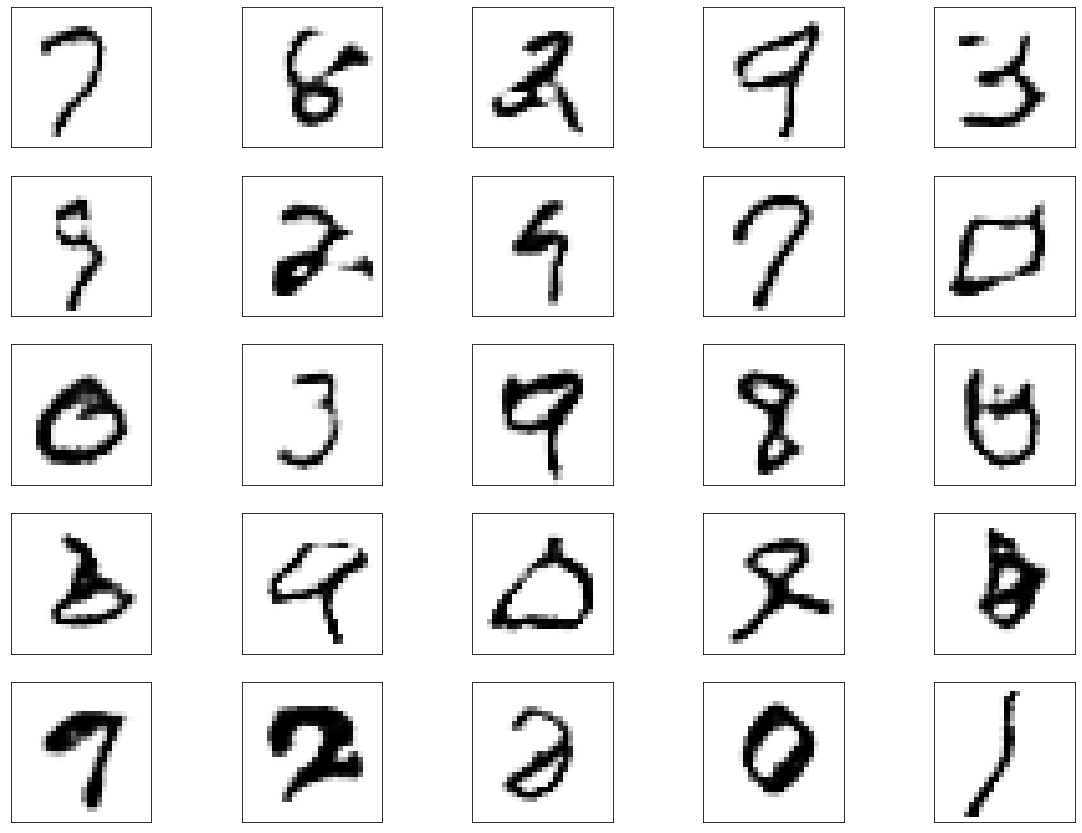

In [16]:
fig = plt.figure(figsize=(20, 15))
for i in range(25):
    ax = fig.add_subplot(5, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(X[i, :, :, 0], cmap='gray_r')
plt.show()